In [7]:
from datetime import datetime

import isort
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import statsmodels as sm
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch

from functions import *
from scripts import *

set_plot_style()

In [9]:
import isort

code = """

import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import isort
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import statsmodels as sm
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch
from functions import *
from scripts import *

set_plot_style()
"""

sorted_code = isort.code(code)
print(sorted_code)




from datetime import datetime

import isort
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import seaborn as sns
import statsmodels as sm
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch

from functions import *
from scripts import *

set_plot_style()



In [10]:
set_plot_style()

# Import datasets

In [12]:
data = import_and_preprocess_data_stock()
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Volatility,Return,Log_Return
0,2013-01-02 00:00:00-05:00,16.814443,16.850269,16.444345,16.669014,560518000,0.0,0.0,0.405924,NaN,NaN
1,2013-01-03 00:00:00-05:00,16.634106,16.688452,16.425223,16.458620,352965200,0.0,0.0,0.263229,-0.012622,-0.012702
2,2013-01-04 00:00:00-05:00,16.302868,16.353267,15.964647,16.000170,594333600,0.0,0.0,0.388620,-0.027855,-0.028250
3,2013-01-07 00:00:00-05:00,15.848357,16.069990,15.641903,15.906043,484156400,0.0,0.0,0.428087,-0.005883,-0.005900
4,2013-01-08 00:00:00-05:00,16.067263,16.148630,15.825592,15.948855,458707200,0.0,0.0,0.323039,0.002692,0.002688
...,...,...,...,...,...,...,...,...,...,...,...
2513,2022-12-23 00:00:00-05:00,129.415299,130.898059,128.150012,130.344498,63814900,0.0,0.0,2.748047,-0.002798,-0.002802
2514,2022-12-27 00:00:00-05:00,129.869997,129.899651,127.240566,128.535507,69007800,0.0,0.0,2.659085,-0.013879,-0.013976
2515,2022-12-28 00:00:00-05:00,128.179661,129.524031,124.423341,124.591385,85438400,0.0,0.0,5.100691,-0.030685,-0.031166
2516,2022-12-29 00:00:00-05:00,126.518963,128.980342,126.261956,128.120346,75703700,0.0,0.0,2.718386,0.028324,0.027931


In [6]:
tweets = import_and_preprocess_data_tweets()
display(tweets)

,id,body,date,user,source,symbols,owned_symbols,mentioned_users,entities,conversation,likes,links,reshares,reshare_message,structurable
0,188952625,$AAPL there is some smarty money trimming into...,2020-01-03,"{'id': 646025, 'username': 'WalterWhitesMoney'...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...","['9', '4', '5', '0', '5', '12', '0', '0', '0',...",[],{'sentiment': None},None,None,None,None,None,None
1,188952404,$AAPL boom!,2020-01-03,"{'id': 2975791, 'username': 'IntradayTradesmen...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...","['21', '12', '9', '0', '9', '5', '0', '4', '0'...",[],{'sentiment': None},None,None,None,None,None,None
2,188952295,$AAPL this pos will not fall below mid VWAP.,2020-01-03,"{'id': 2975791, 'username': 'IntradayTradesmen...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...","['20', '11', '9', '0', '9', '5', '0', '4', '0'...",[],{'sentiment': None},"{'parent_message_id': 188952295, 'in_reply_to_...",None,None,None,None,None
3,188952260,$AAPL I am holding going to see what this bab...,2020-01-03,"{'id': 2083522, 'username': 'robertlooney', 'n...","{'id': 2095, 'title': 'StockTwits For Android ...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...","['4', '4', '0', '0', '0', '3', '0', '0', '0', ...",[],{'sentiment': {'basic': 'Bullish'}},None,"{'total': 1, 'user_ids': [881009]}",None,None,None,None
4,188951817,$SPY is $AAPL over priced is the average analy...,2020-01-03,"{'id': 1581841, 'username': 'CaymanStyleBeef',...","{'id': 2095, 'title': 'StockTwits For Android ...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...","['3', '2', '1', '0', '1', '1', '0', '1', '0', ...",[],{'sentiment': None},"{'parent_message_id': 188951817, 'in_reply_to_...",None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914957,433483243,$AAPL break 171 and she flushes,2022-02-04,"{'id': 6291642, 'username': 'Russianrussian', ...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...",None,[],{'sentiment': {'basic': 'Bearish'}},"{'parent_message_id': 433483243, 'in_reply_to_...","{'total': 2, 'user_ids': [846449, 3009473]}",None,None,None,None
914958,433483137,$AAPL is a growth stock now?,2022-02-04,"{'id': 6287247, 'username': 'TheMarketIsRigged...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...",None,[],{'sentiment': None},None,None,None,None,None,None
914959,433482209,"$AAPL 🍏 Do you know what time it is…yep, that...",2022-02-04,"{'id': 819540, 'username': 'hoyasaxa1978', 'na...","{'id': 1149, 'title': 'StockTwits for iOS', 'u...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...",None,[],{'sentiment': {'basic': 'Bullish'}},None,None,None,None,None,None
914960,433482173,"$AAPL lol u buy the dip on it, not like $tsla",2022-02-04,"{'id': 1223497, 'username': 'RNAlivesmatter', ...","{'id': 2269, 'title': 'StockTwits Web', 'url':...","[{'id': 686, 'symbol': 'AAPL', 'title': 'Apple...",None,[],{'sentiment': {'basic': 'Bullish'}},None,None,None,None,None,None


# EDA

## EDA - Apple Stock Price

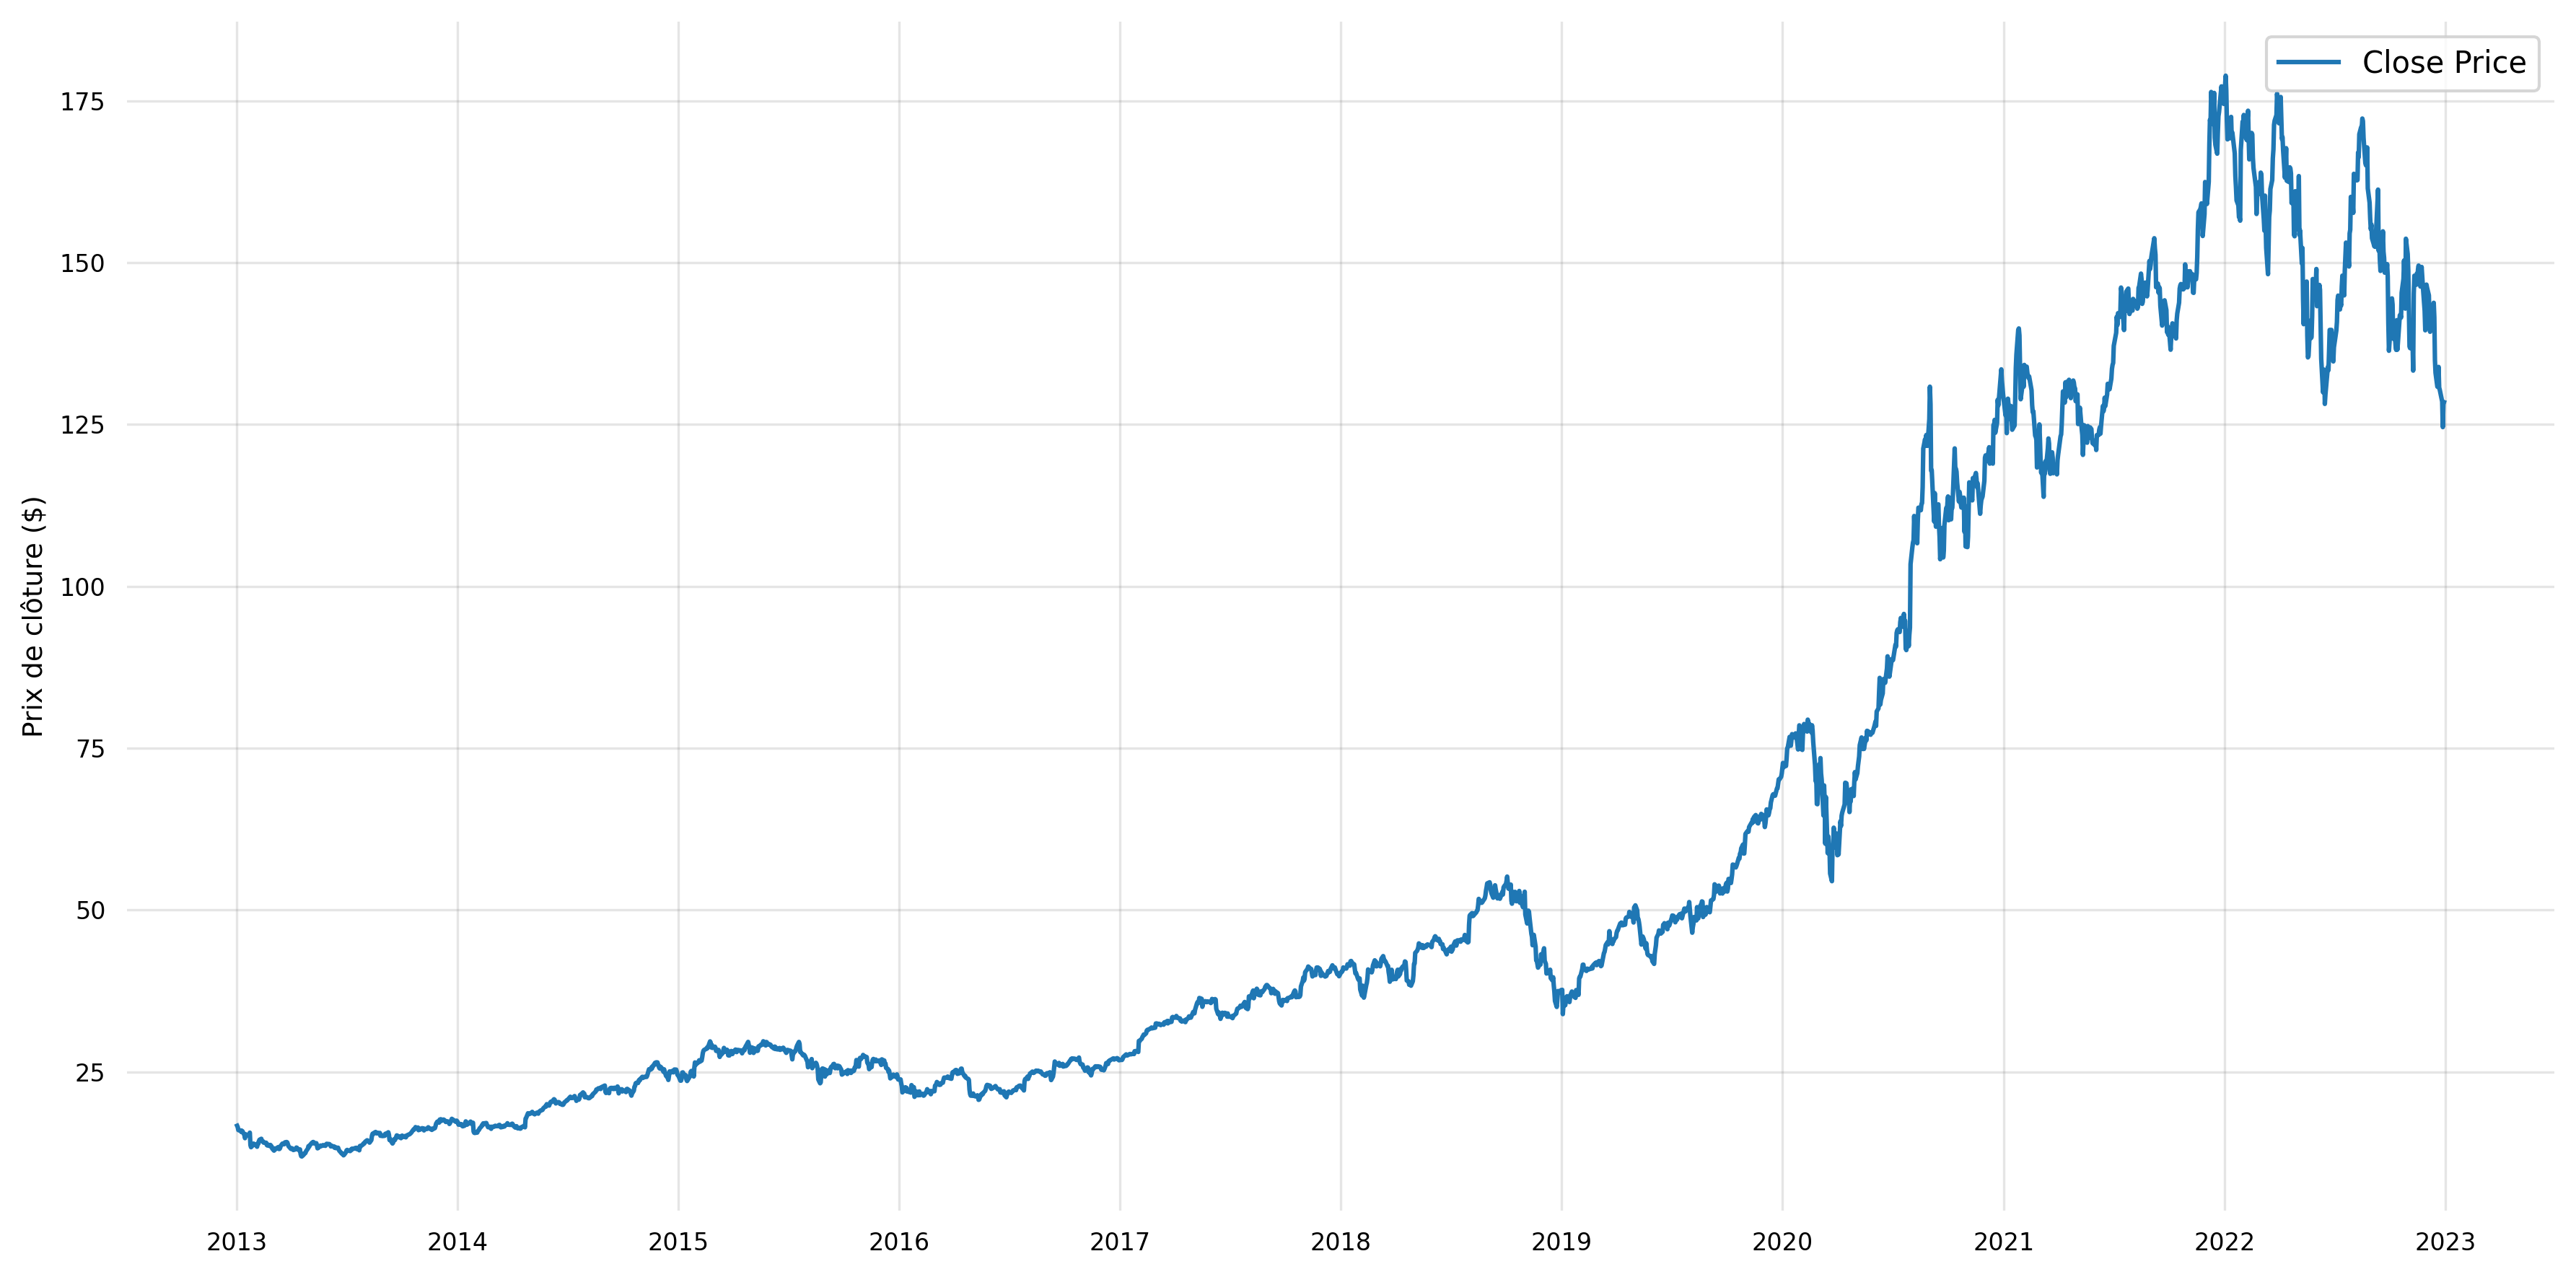

In [13]:
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.ylabel("Prix de clôture ($)")
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
fig = go.Figure(data=[go.Candlestick(x=data['Date'],
                open=data['Open'], high=data['High'],
                low=data['Low'], close=data['Close'])])
fig.update_layout(
    xaxis_rangeslider_visible=False,
    margin=dict(l=20, r=20, t=30, b=20)  # l=left, r=right, t=top, b=bottom
)
fig.show()

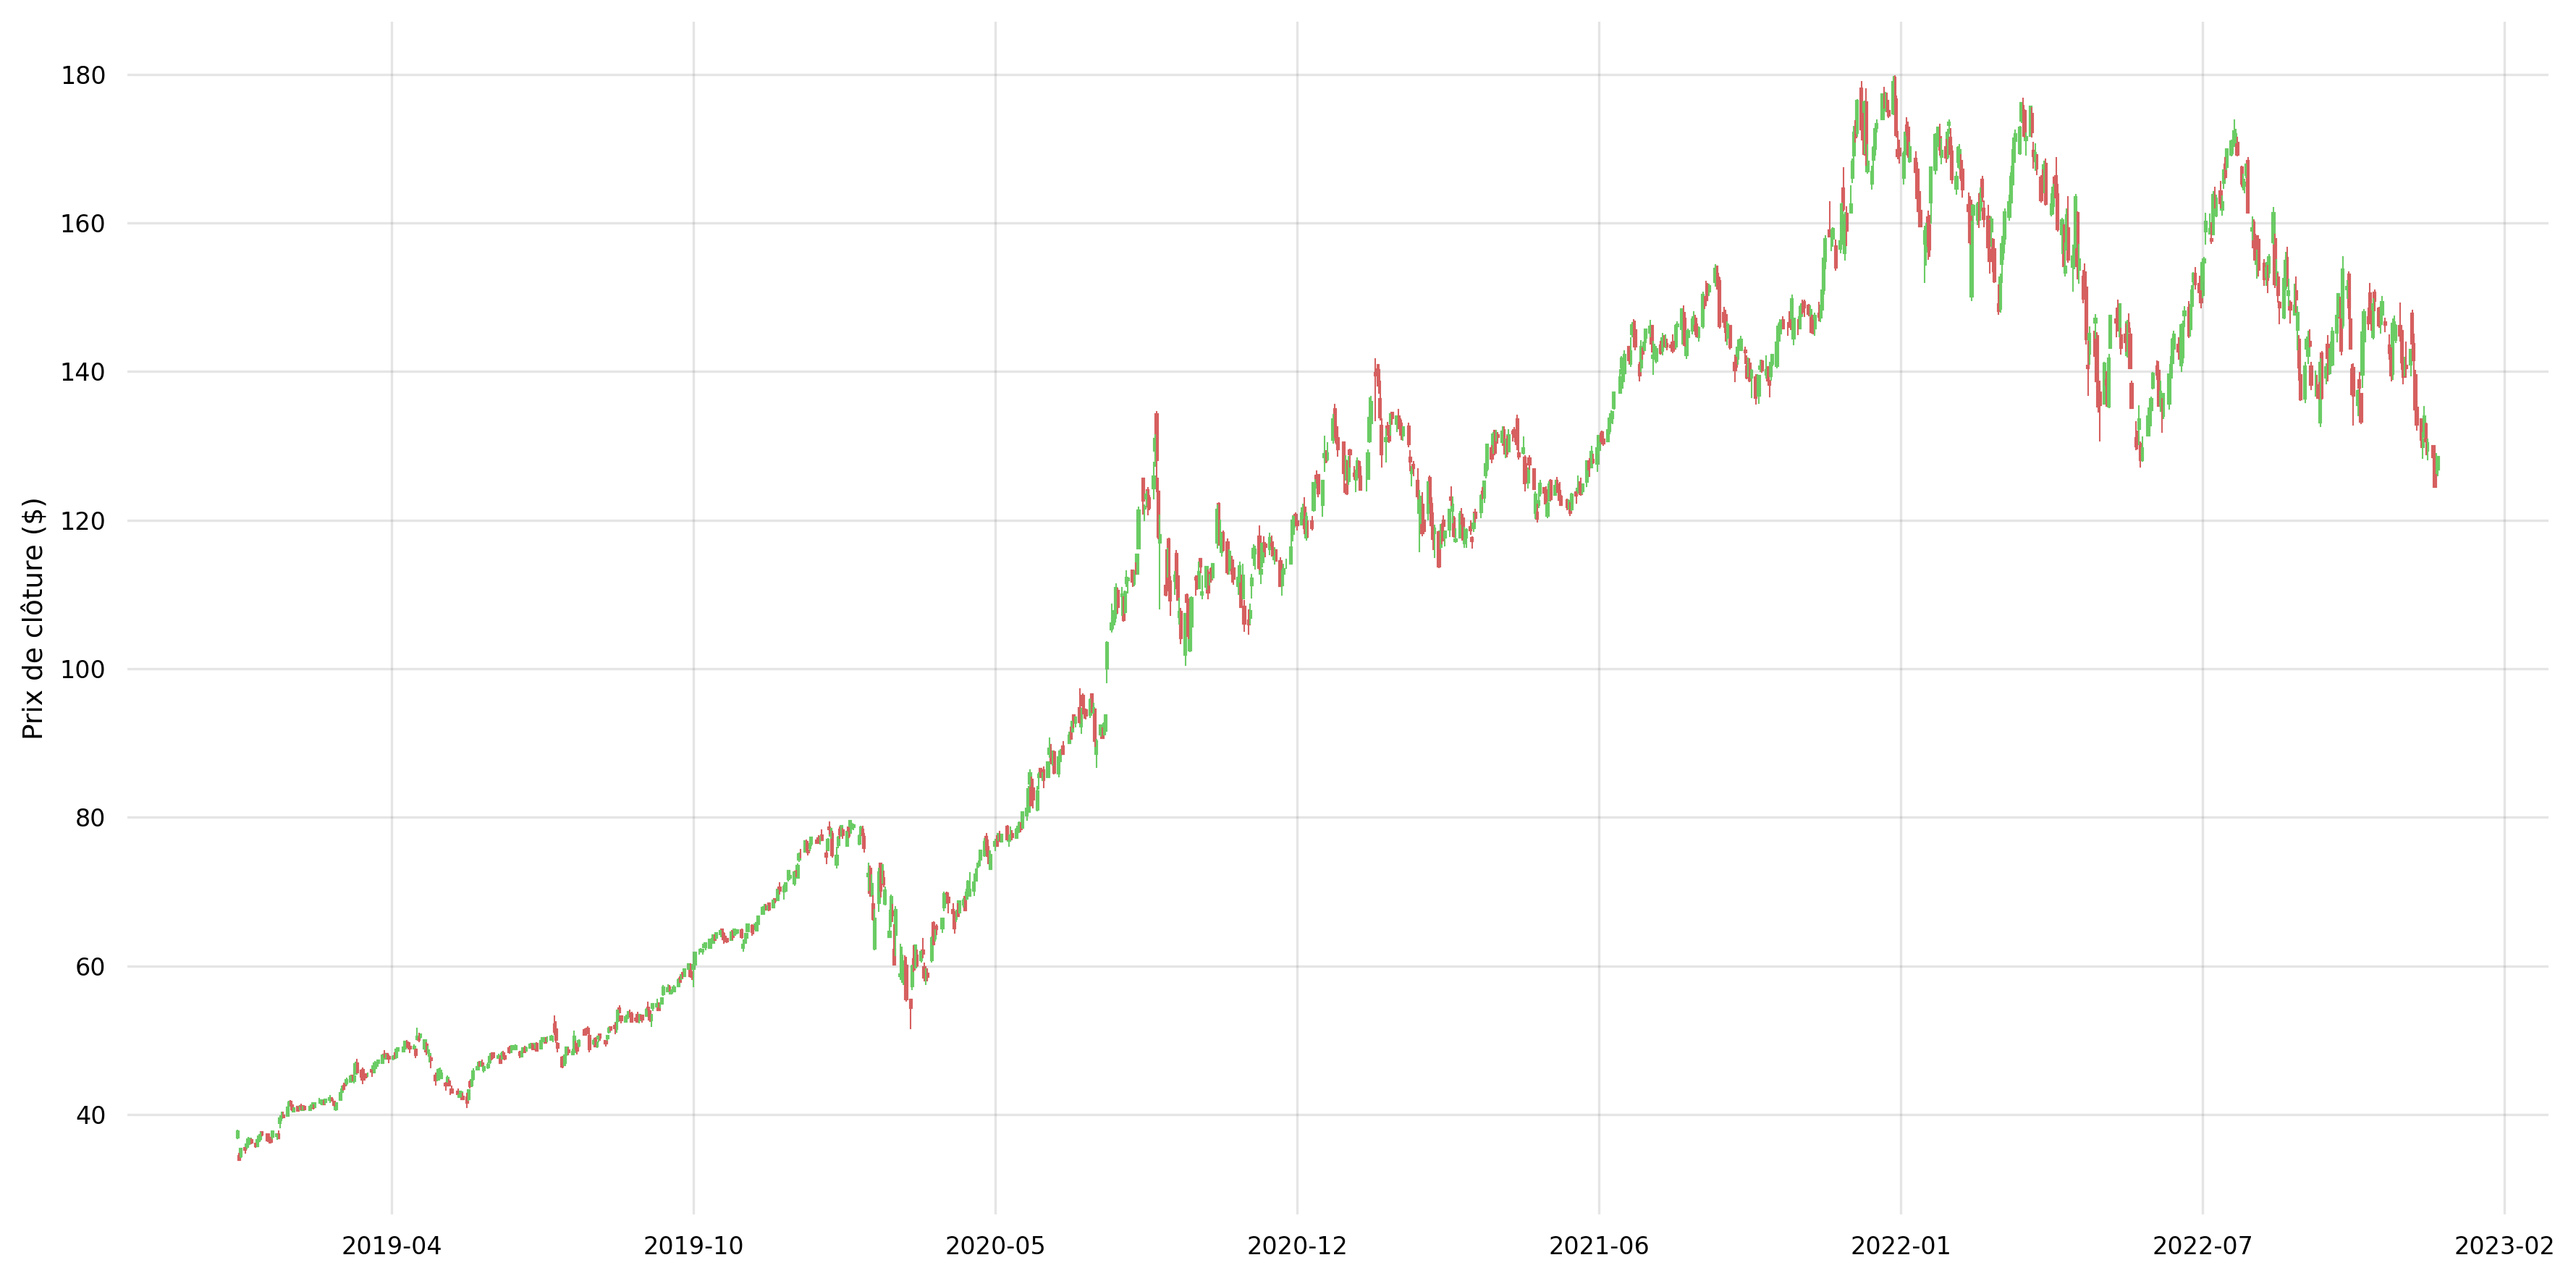

In [40]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DateFormatter
from matplotlib import ticker
from matplotlib.patches import Rectangle
import pandas as pd
from mplfinance.original_flavor import candlestick_ohlc
data['Date_num'] = date2num(data['Date'])
data['MA10'] = data['Close'].rolling(window=10).mean()
data['MA2'] = data['Close'].rolling(window=2).mean()
quotes = [tuple(x) for x in data[['Date_num', 'Open', 'High', 'Low', 'Close']].values]

# Plot
fig, ax = plt.subplots(figsize=(12, 6))  # You can set tight layout manually
from mplfinance.original_flavor import candlestick_ohlc
candlestick_ohlc(ax, quotes, width=0.6, colorup='g', colordown='r')

# Format x-axis
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.ylabel("Prix de clôture ($)")
# Tight layout
plt.tight_layout()
plt.show()

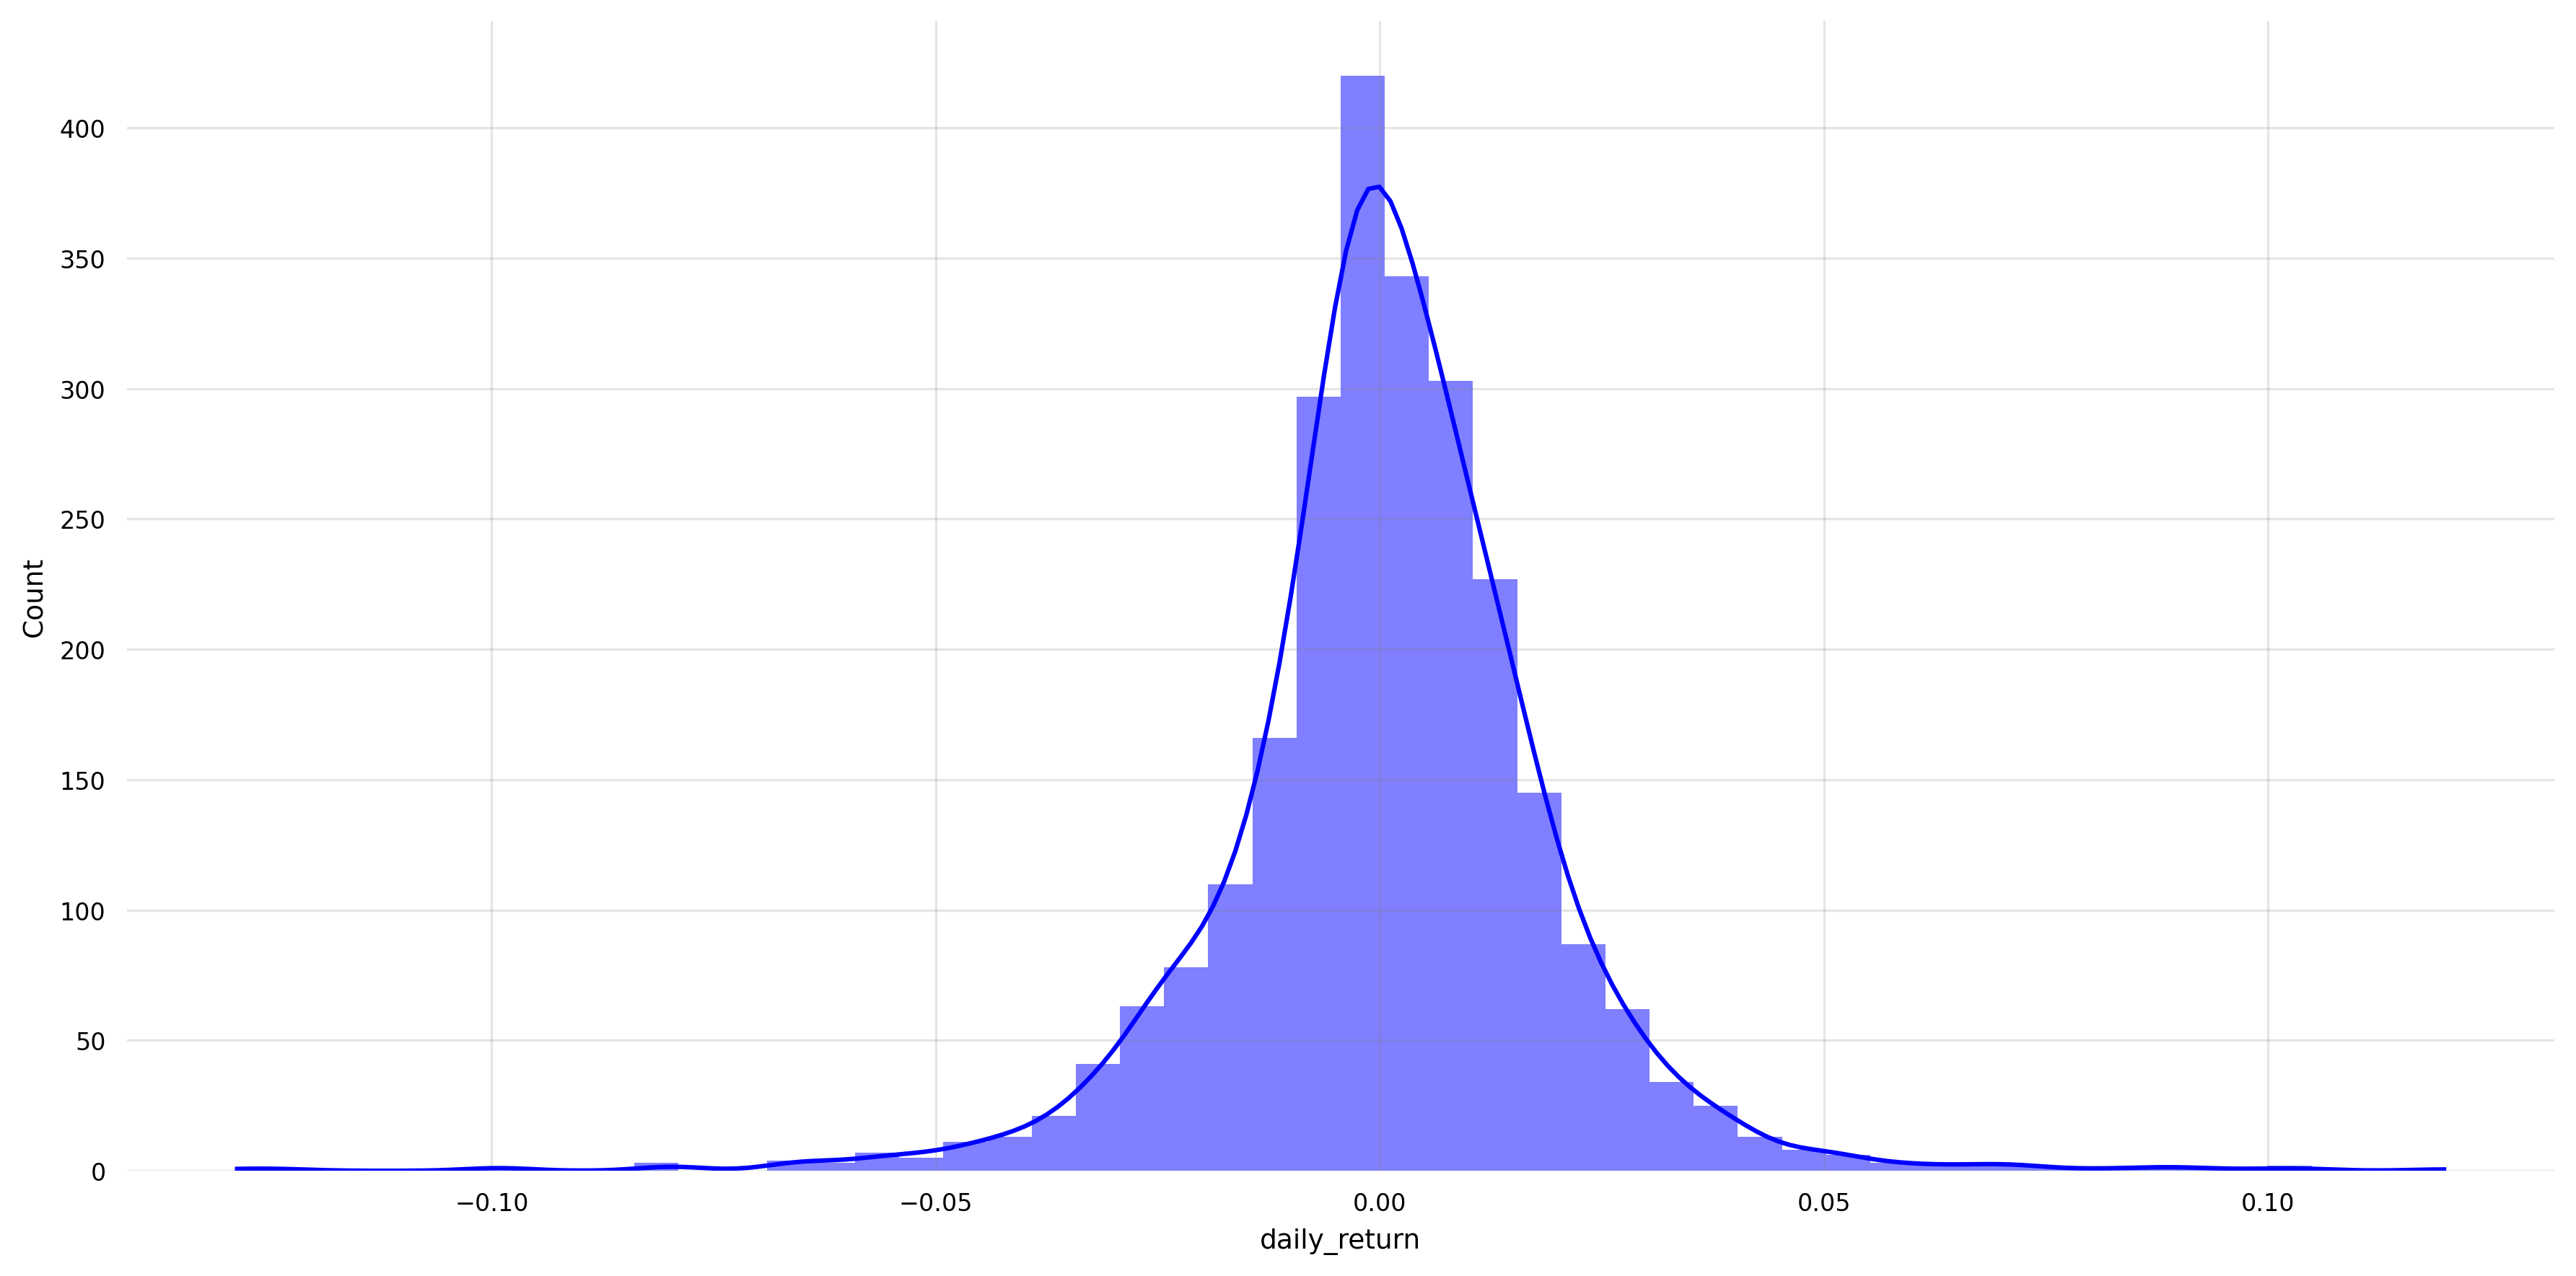

In [25]:
data['daily_return'] = data['Close'].pct_change()
sns.histplot(data['daily_return'], bins=50, kde=True, alpha=0.5, color='blue', edgecolor=None)
plt.tight_layout()

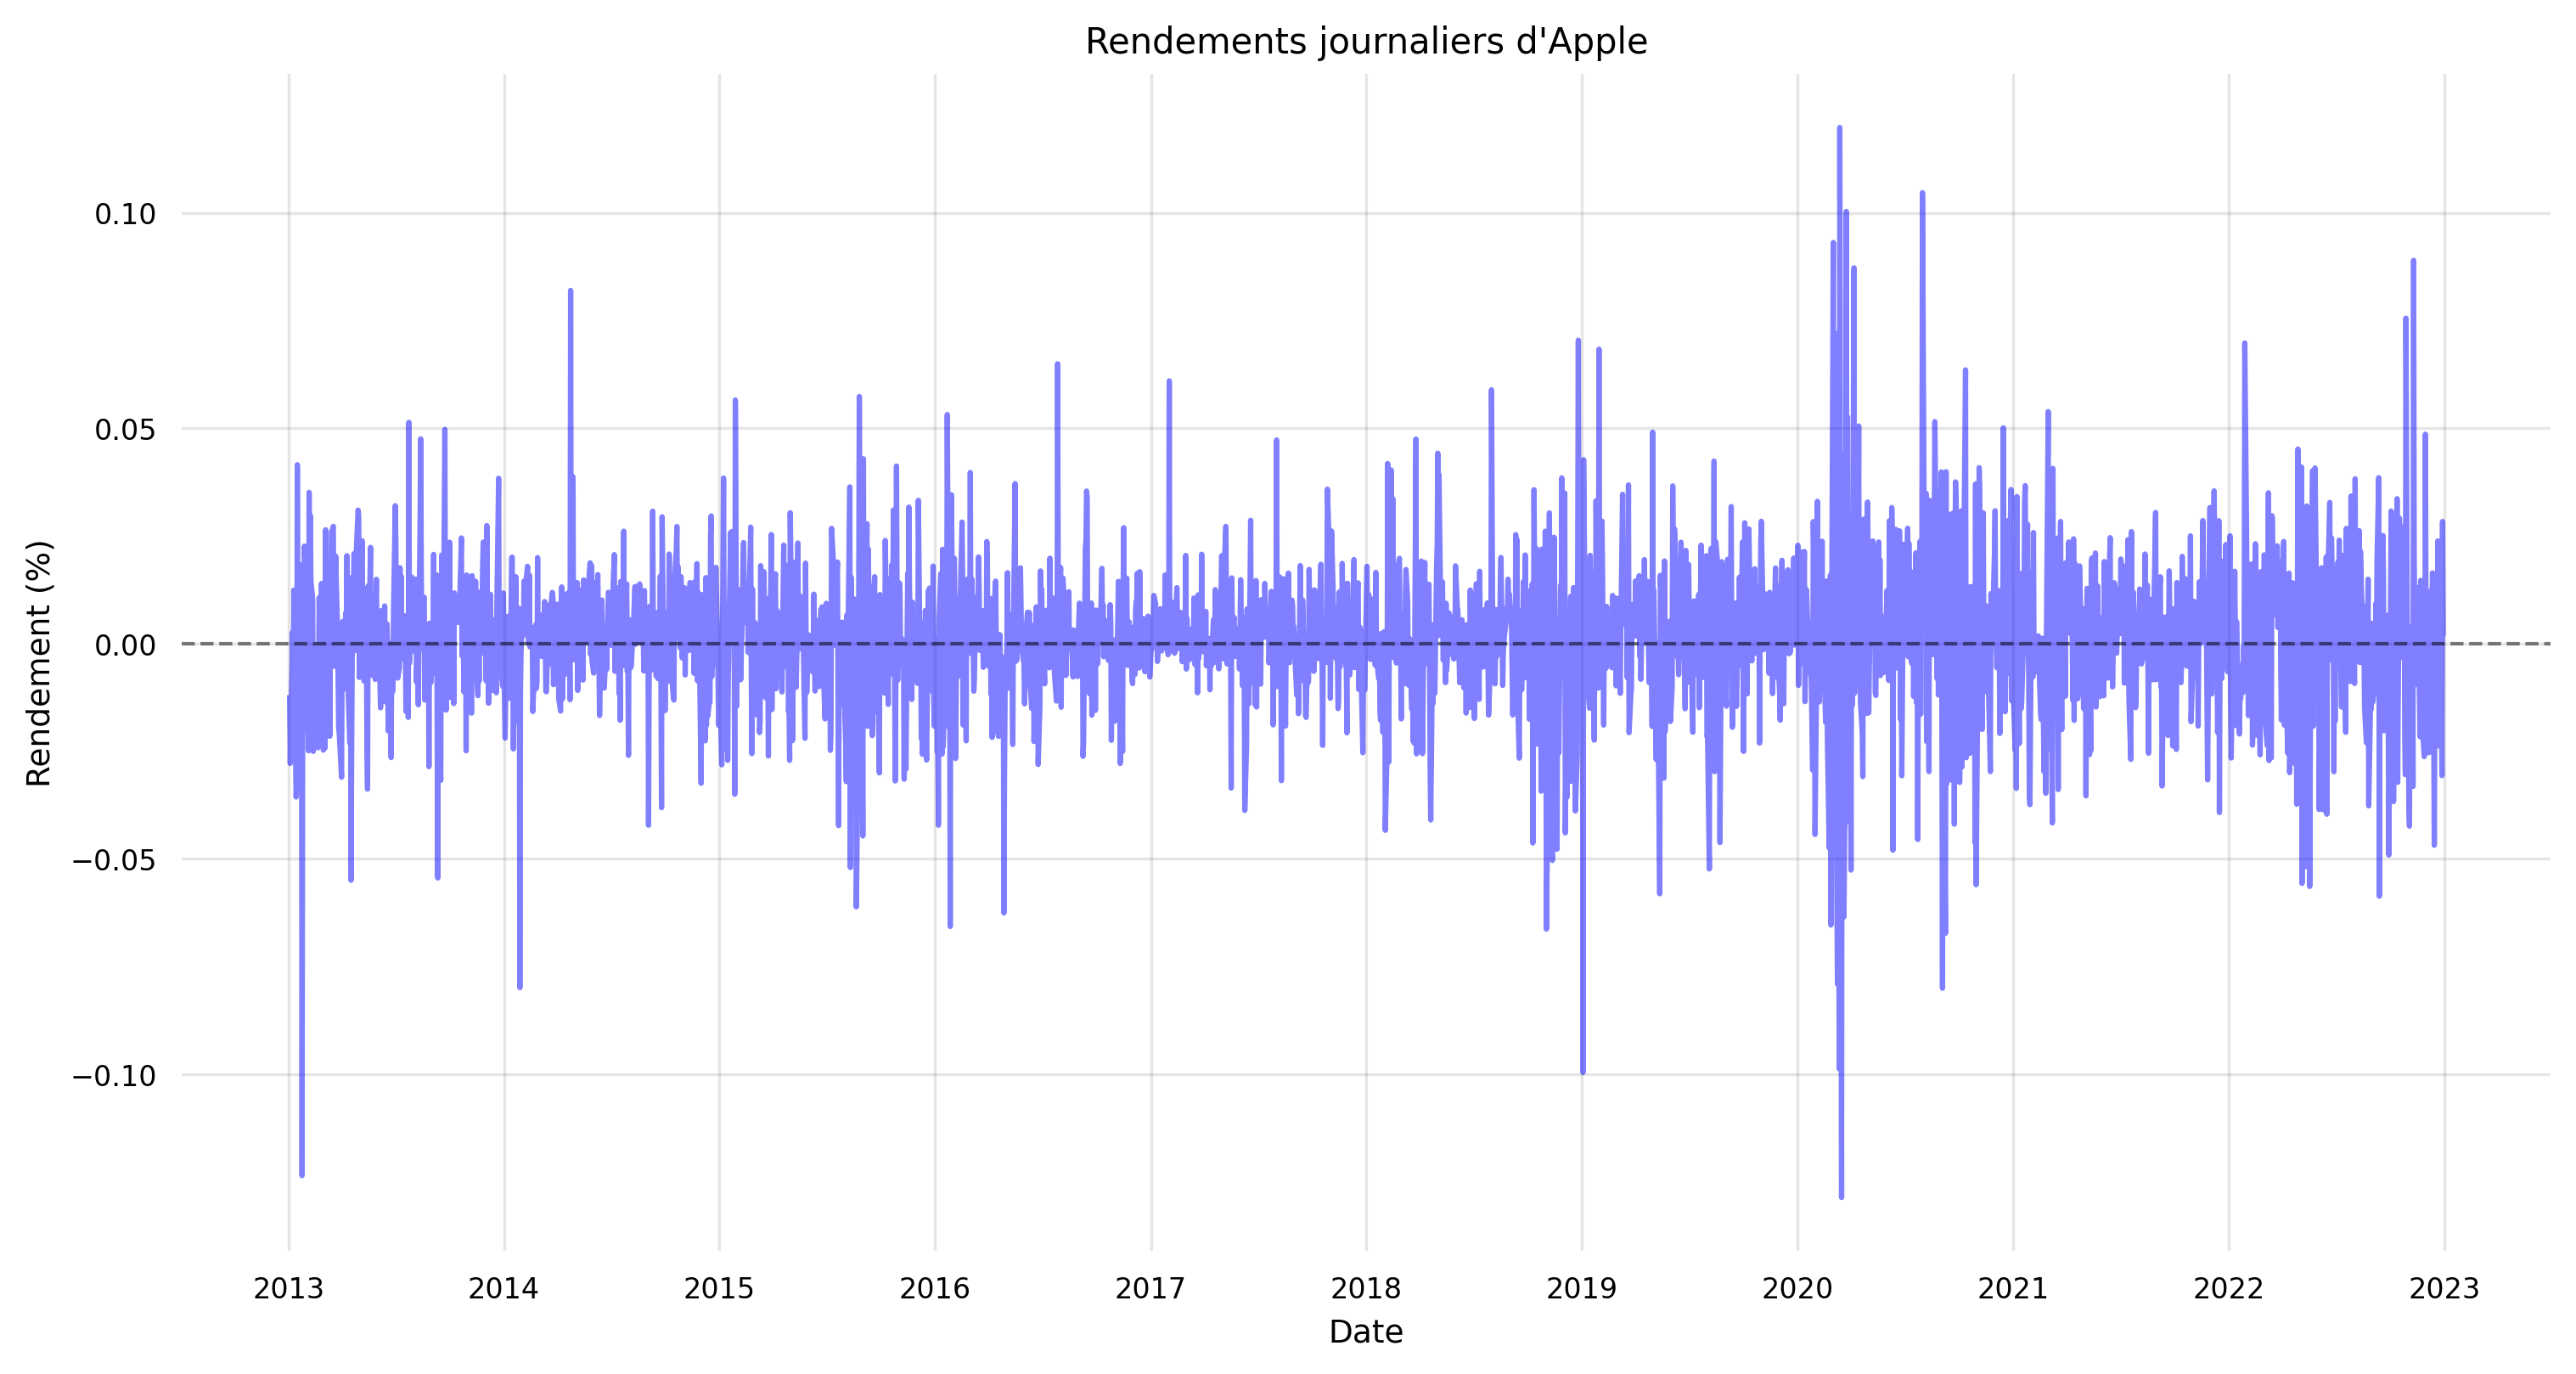

In [26]:
plt.plot(data['Date'], data['daily_return'], color="blue", alpha=0.5)
plt.title("Rendements journaliers d'Apple")
plt.axhline(0, color='black', linewidth=1, linestyle='--', alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Rendement (%)")
plt.show()


In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Assume `data` is your DataFrame
correlation_matrix = data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()

# Use Pandas Styler to apply a heatmap style
styled_corr = correlation_matrix.style.background_gradient(cmap='coolwarm')

styled_corr

,Open,High,Low,Close,Volume
Open,1.000000,0.999624,0.999525,0.998979,-0.325572
High,0.999624,1.000000,0.999462,0.999522,-0.317388
Low,0.999525,0.999462,1.000000,0.999539,-0.336011
Close,0.998979,0.999522,0.999539,1.000000,-0.327085
Volume,-0.325572,-0.317388,-0.336011,-0.327085,1.000000


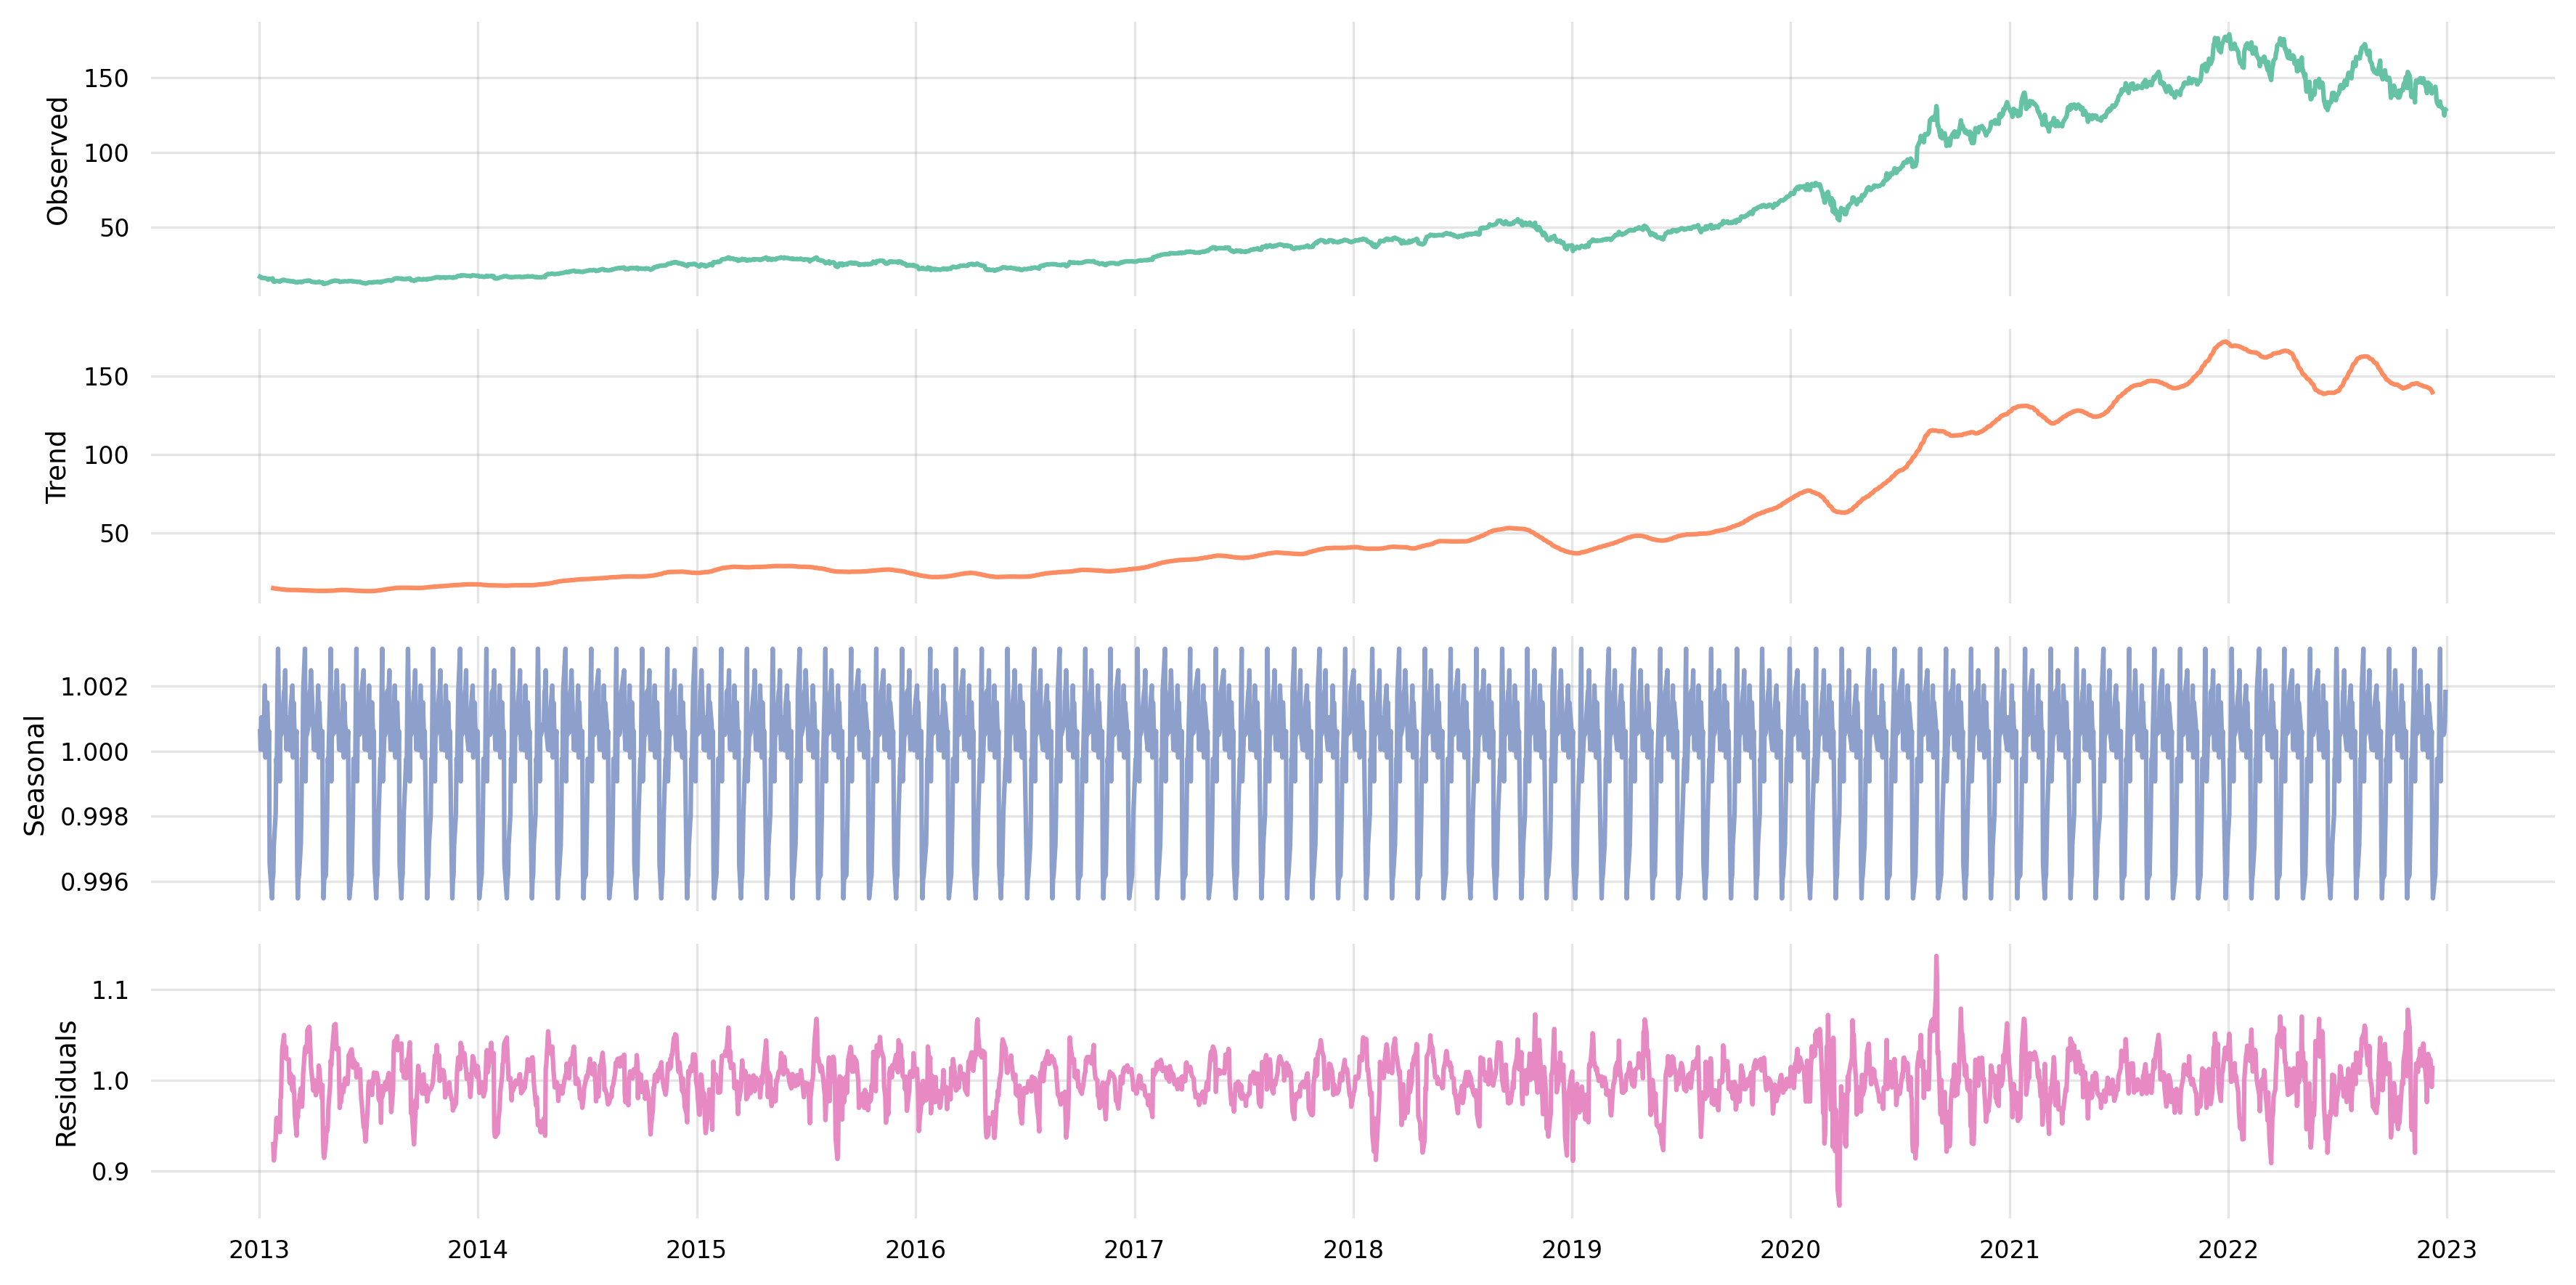

In [27]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Effectuer la décomposition
result = seasonal_decompose(data.set_index('Date')['Close'], model='multiplicative', period=30)

# Initialiser la figure avec 4 sous-graphes
fig, axes = plt.subplots(4, 1, figsize=(12, 6), sharex=True)
components = ['observed', 'trend', 'seasonal', 'resid']
titles = ['Observed', 'Trend', 'Seasonal', 'Residuals']
colors = px.colors.qualitative.Plotly[:4]
colors = sns.color_palette("Set2")[:4]
# Tracer chaque composante
for ax, comp, title, color in zip(axes, components, titles, colors):
    series = getattr(result, comp)
    ax.plot(series, label=title, color=color)
    ax.set_ylabel(title)
    ax.grid(True)

# Titre général et ajustement
plt.tight_layout() 
plt.show()


In [28]:
model = arch_model(data['Log_Return'].dropna(), vol='Garch', p=1, q=1, rescale = False)
results = model.fit(disp='off')
residuals = results.resid
squared_residuals = residuals**2
arch_test = het_arch(squared_residuals)
print(f'ARCH test results:\n')
print(f'LM Statistic: {arch_test[0]}')
print(f'p-value: {arch_test[1]}')
print(f'F Statistic: {arch_test[2]}')
print(f'p-value: {arch_test[3]}')

KeyError: 'Log_Return'

In [48]:
model = arch_model(data['Log_Return'].dropna(), vol='Arch', p=1, rescale = False)
results = model.fit(disp='off')
print(results.summary())

save_arch_results_to_latex(results, p=1, q=None, model_type="ARCH")

                      Constant Mean - ARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                2468.60
Distribution:                  Normal   AIC:                          -4931.20
Method:            Maximum Likelihood   BIC:                          -4916.46
                                        No. Observations:                 1007
Date:               sam., mai 03 2025   Df Residuals:                     1006
Time:                        19:18:02   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.9307e-03  6.719e-04      2.873  4.060e-03 [6.

In [12]:
model = arch_model(data['Log_Return'].dropna(), vol='Arch', p=2, rescale = False)
results = model.fit(disp='off')
print(results.summary())

                      Constant Mean - ARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                2499.61
Distribution:                  Normal   AIC:                          -4991.22
Method:            Maximum Likelihood   BIC:                          -4971.56
                                        No. Observations:                 1007
Date:               sam., mai 03 2025   Df Residuals:                     1006
Time:                        18:46:04   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.9755e-03  5.916e-04      3.339  8.408e-04 [8.

In [18]:
model = arch_model(data['Log_Return'].dropna(), vol='Garch', p=1, q=1, rescale = False)
results = model.fit(disp='off')
print(results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             Log_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2537.13
Distribution:                  Normal   AIC:                          -5066.26
Method:            Maximum Likelihood   BIC:                          -5046.60
                                        No. Observations:                 1007
Date:               sam., mai 03 2025   Df Residuals:                     1006
Time:                        18:47:27   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         2.2452e-03  6.176e-04      3.636  2.774e-04 [1.

In [20]:
from tabulate import tabulate

table = zip(results.params.index, results.params, results.std_err, results.tvalues, results.pvalues)
latex_table = tabulate(table, headers=["Param", "Coef", "Std Err", "t", "P>|t|"], tablefmt="latex")
print(latex_table)


\begin{tabular}{lrrrr}
\hline
 Param    &        Coef &     Std Err &            t &       P\ensuremath{>}|t| \\
\hline
 mu       & 0.00224515  & 0.000617558 &      3.63554 & 0.000277401 \\
 omega    & 9.49877e-06 & 1.00832e-11 & 942038       & 0           \\
 alpha[1] & 0.100002    & 0.0228207   &      4.38208 & 1.17552e-05 \\
 beta[1]  & 0.879998    & 0.0180742   &     48.688   & 0           \\
\hline
\end{tabular}


In [258]:
# Convert the summary to a string
summary_str = best_model.summary().as_text()

# Write the summary to a LaTeX file or buffer
with open("model_summary.tex", "w") as buf:
	buf.write(summary_str)

In [244]:
from arch import arch_model
best_aic = np.inf
returns = data['Close'].dropna()
for p,q in combinations(np.arange(1,11), 2):
    model = arch_model(returns, vol='Garch', p=int(p), q=int(q))
    result_temp = model.fit(disp='off')
    if result_temp.aic < best_aic:
        best_aic = result_temp.aic
        best_combo = (i, j)
        best_model = result_temp
print(f"Meilleure combinaison : {best_combo} avec AIC = {best_aic}")
result_temp.summary()  # Afficher le résumé du modèle

Meilleure combinaison : (np.int64(9), np.int64(10)) avec AIC = 9384.948562931242


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4686.82
Distribution:                  Normal   AIC:                           9415.63
Method:            Maximum Likelihood   BIC:                           9518.86
                                        No. Observations:                 1008
Date:               ven., mai 02 2025   Df Residuals:                     1007
Time:                        23:30:49   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           142.8531      1.441     99.158      0.000 [1.400e+02,1.457e+02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          4.4522      4.963      0.897      0.370 [ -5.275, 14.180]
alpha[1]       0.8130      0.122      6.655  2.838e-11 [  0.574,  1.052]
alpha[2]       0.0162      0.588  2.753e-02      0.978 [ -1.137,  1.170]
alpha[3]       0.1509      0.793      0.190      0.849 [ -1.403,  1.705]
alpha[4]   2.2092e-12      0.488  4.523e-12      1.000 [ -0.957,  0.957]
alpha[5]   2.9148e-12      0.645  4.520e-12      1.000 [ -1.264,  1.264]
alpha[6]   3.3568e-12      0.626  5.362e-12      1.000 [ -1.227,  1.227]
alpha[7]   3.6847e-12      0.277  1.329e-11      1.000 [ -0.543,  0.543]
alpha[8]   3.1492e-12      0.363  8.682e-12      1.000 [ -0.711,  0.711]
alpha[9]       0.0116      0.437  2.660e-02      0.979 [ -0.845,  0.868]
beta[1]    7.4138e-13      0.717  1.033e-12      1.000 [ -1.406,  1.406]
beta[2]        0.0000      0.891      0.000      1.000 [ -1.747,  1.747]
beta[3]    2.0496e-13      0.633  3.237e-13      1.000 [ -1.241,  1.241]
beta[4]    8.9948e-13      0.810  1.110e-12      1.000 [ -1.588,  1.588]
beta[5]    1.2559e-12      0.807  1.556e-12      1.000 [ -1.582,  1.582]
beta[6]    8.6529e-13      0.414  2.092e-12      1.000 [ -0.811,  0.811]
beta[7]    1.0580e-12      0.368  2.877e-12      1.000 [ -0.721,  0.721]
beta[8]        0.0000      0.490      0.000      1.000 [ -0.960,  0.960]
beta[9]    3.8910e-13  7.233e-02  5.380e-12      1.000 [ -0.142,  0.142]
beta[10]       0.0000  8.710e-02      0.000      1.000 [ -0.171,  0.171]
========================================================================

Covariance estimator: robust
"""

In [ ]:
from scipy.stats import anderson

result = anderson(data['daily_return'][1:])
print(f'Statistic: {result.statistic}')
for i in range(len(result.critical_values)):
    sig_level, crit_val = result.significance_level[i], result.critical_values[i]
    print(f'At {sig_level}% significance level, critical value is {crit_val}')
    if result.statistic < crit_val:
        print('Probably normal')
    else:
        print('Probably not normal')


Statistic: 8.990341580251084
At 15.0% significance level, critical value is 0.574
Probably not normal
At 10.0% significance level, critical value is 0.653
Probably not normal
At 5.0% significance level, critical value is 0.784
Probably not normal
At 2.5% significance level, critical value is 0.914
Probably not normal
At 1.0% significance level, critical value is 1.088
Probably not normal



Test ADF pour la série d'origine:
ADF Statistic: -1.6680778468463857
p-value: 0.4476302022383
La série n'est pas stationnaire

Test ADF après différenciation :
ADF Statistic: -33.74336710932961
p-value: 0.0
La série est stationnaire


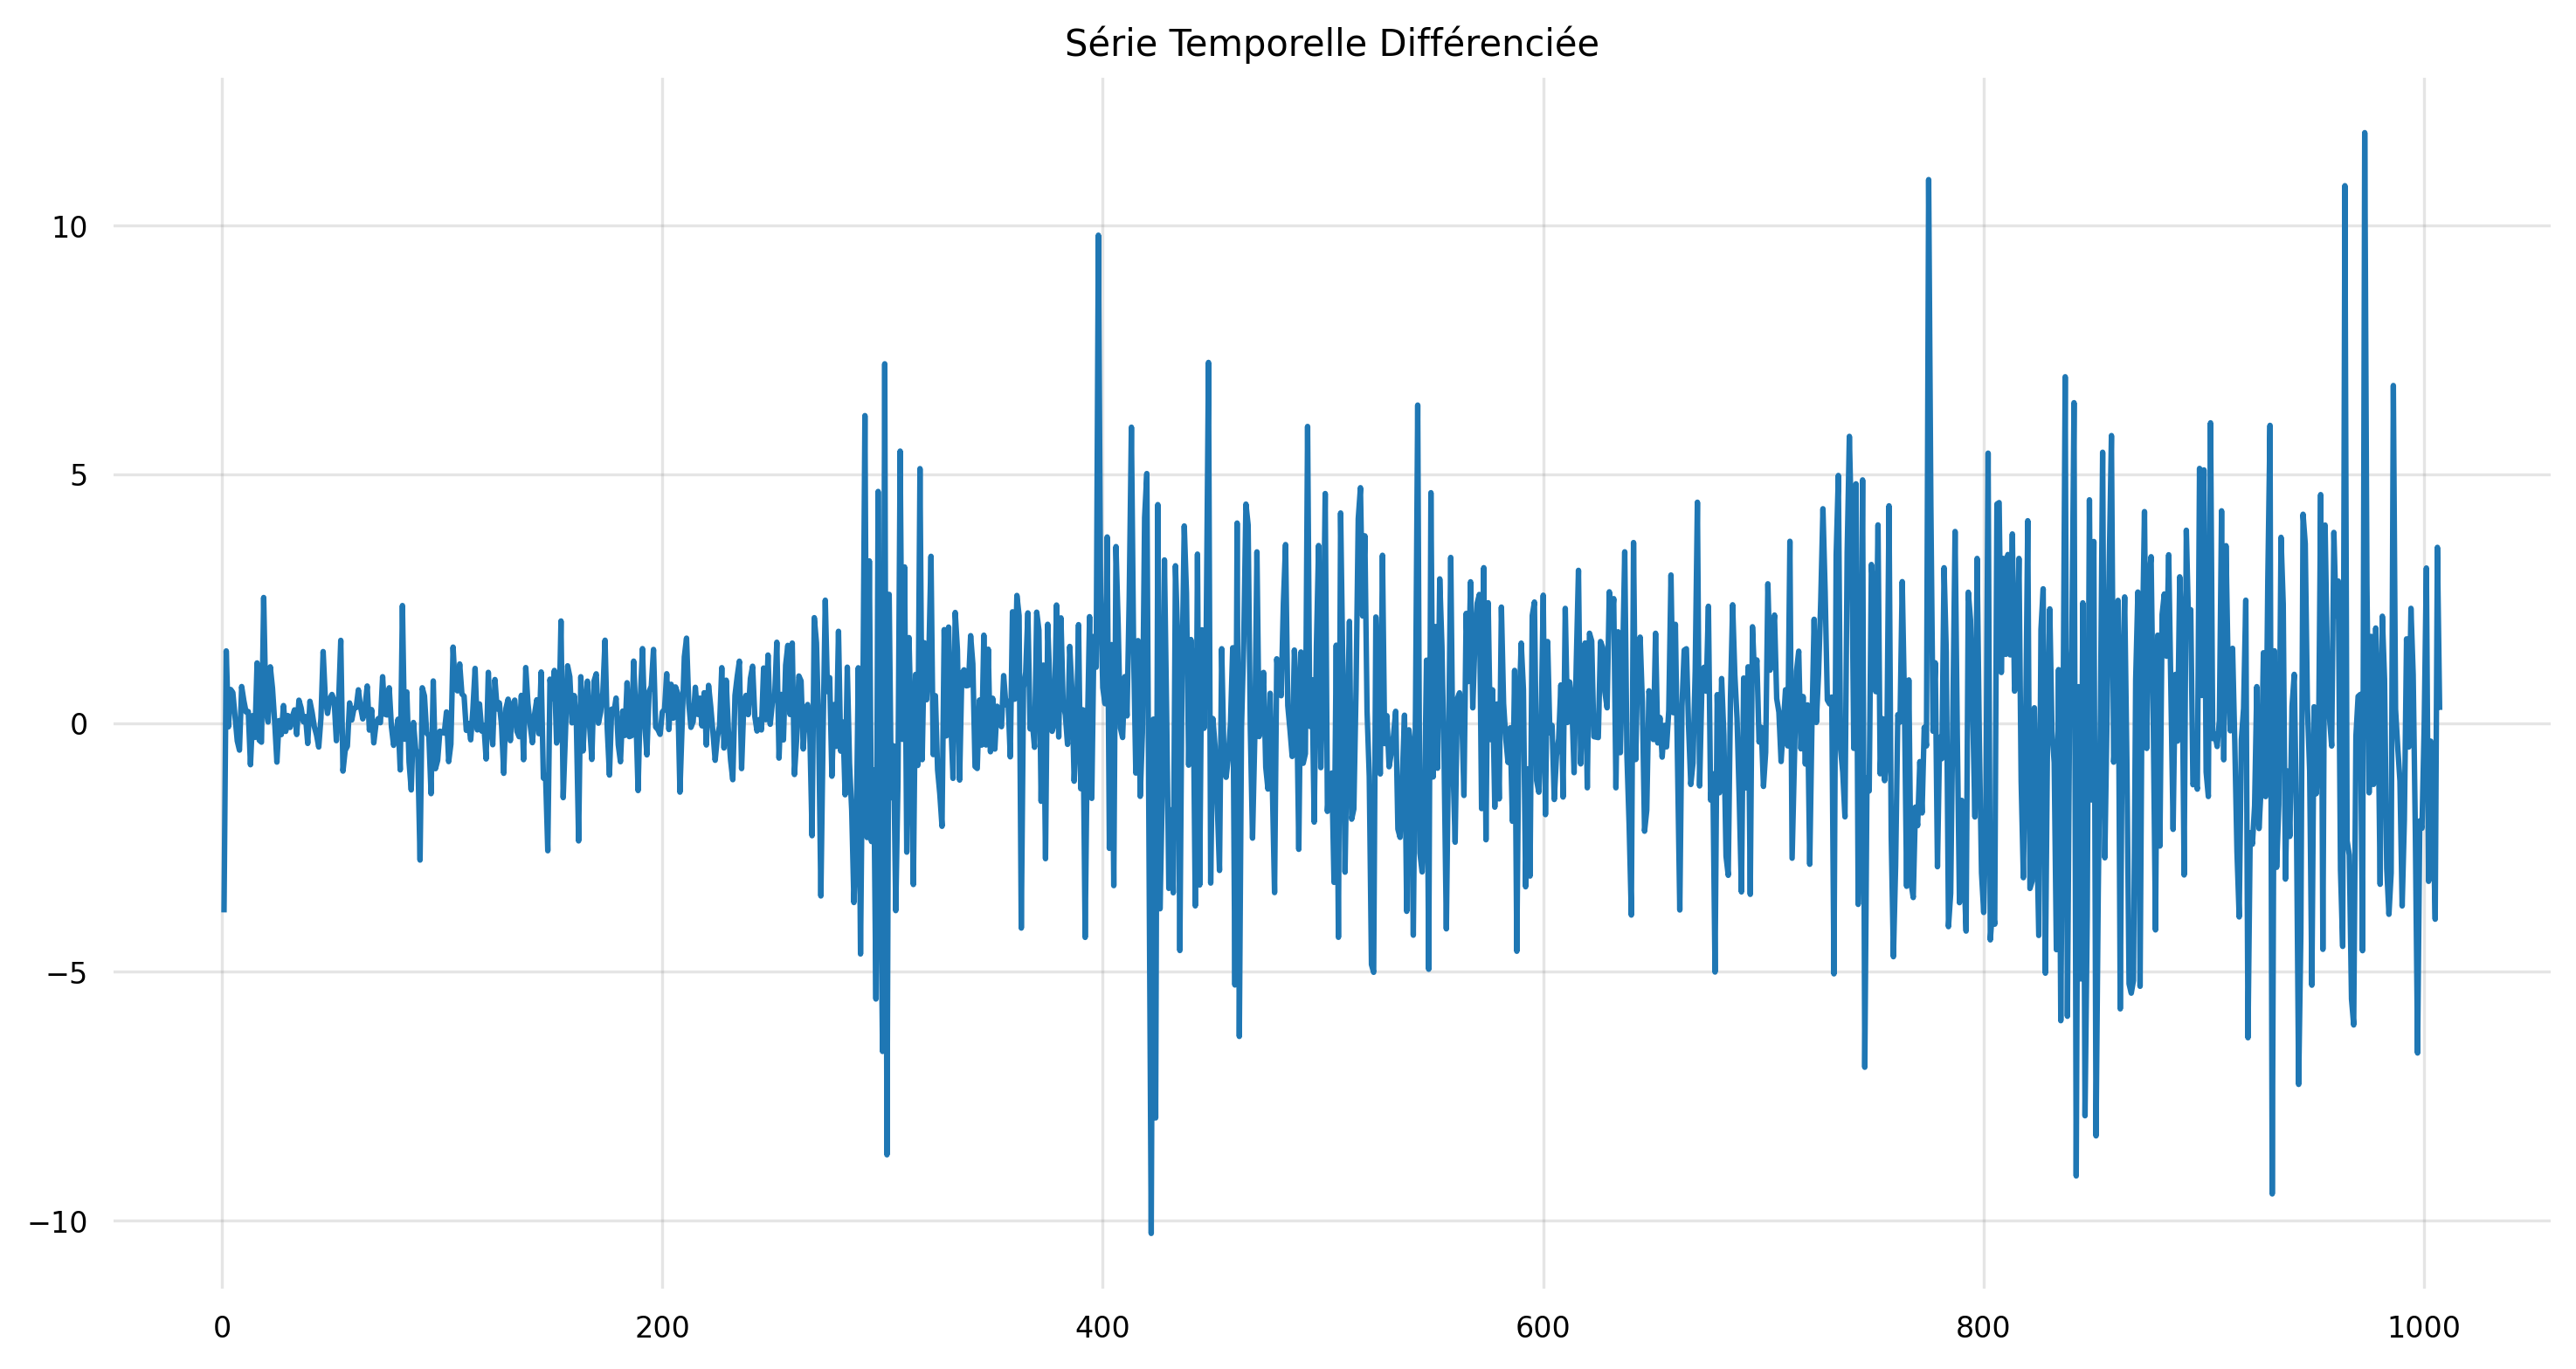

In [8]:
from statsmodels.tsa.stattools import adfuller, acf, pacf


def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print("La série est stationnaire")
    else:
        print("La série n'est pas stationnaire")

print("\nTest ADF pour la série d'origine:")
ts = data['Close'].dropna()
adf_test(ts)

# Différenciation pour rendre la série stationnaire
ts_diff = ts.diff().dropna()
print("\nTest ADF après différenciation :")
adf_test(ts_diff)

plt.figure(figsize=(12, 6))
plt.plot(ts_diff, label='Différenciée')
plt.title('Série Temporelle Différenciée')
plt.show()

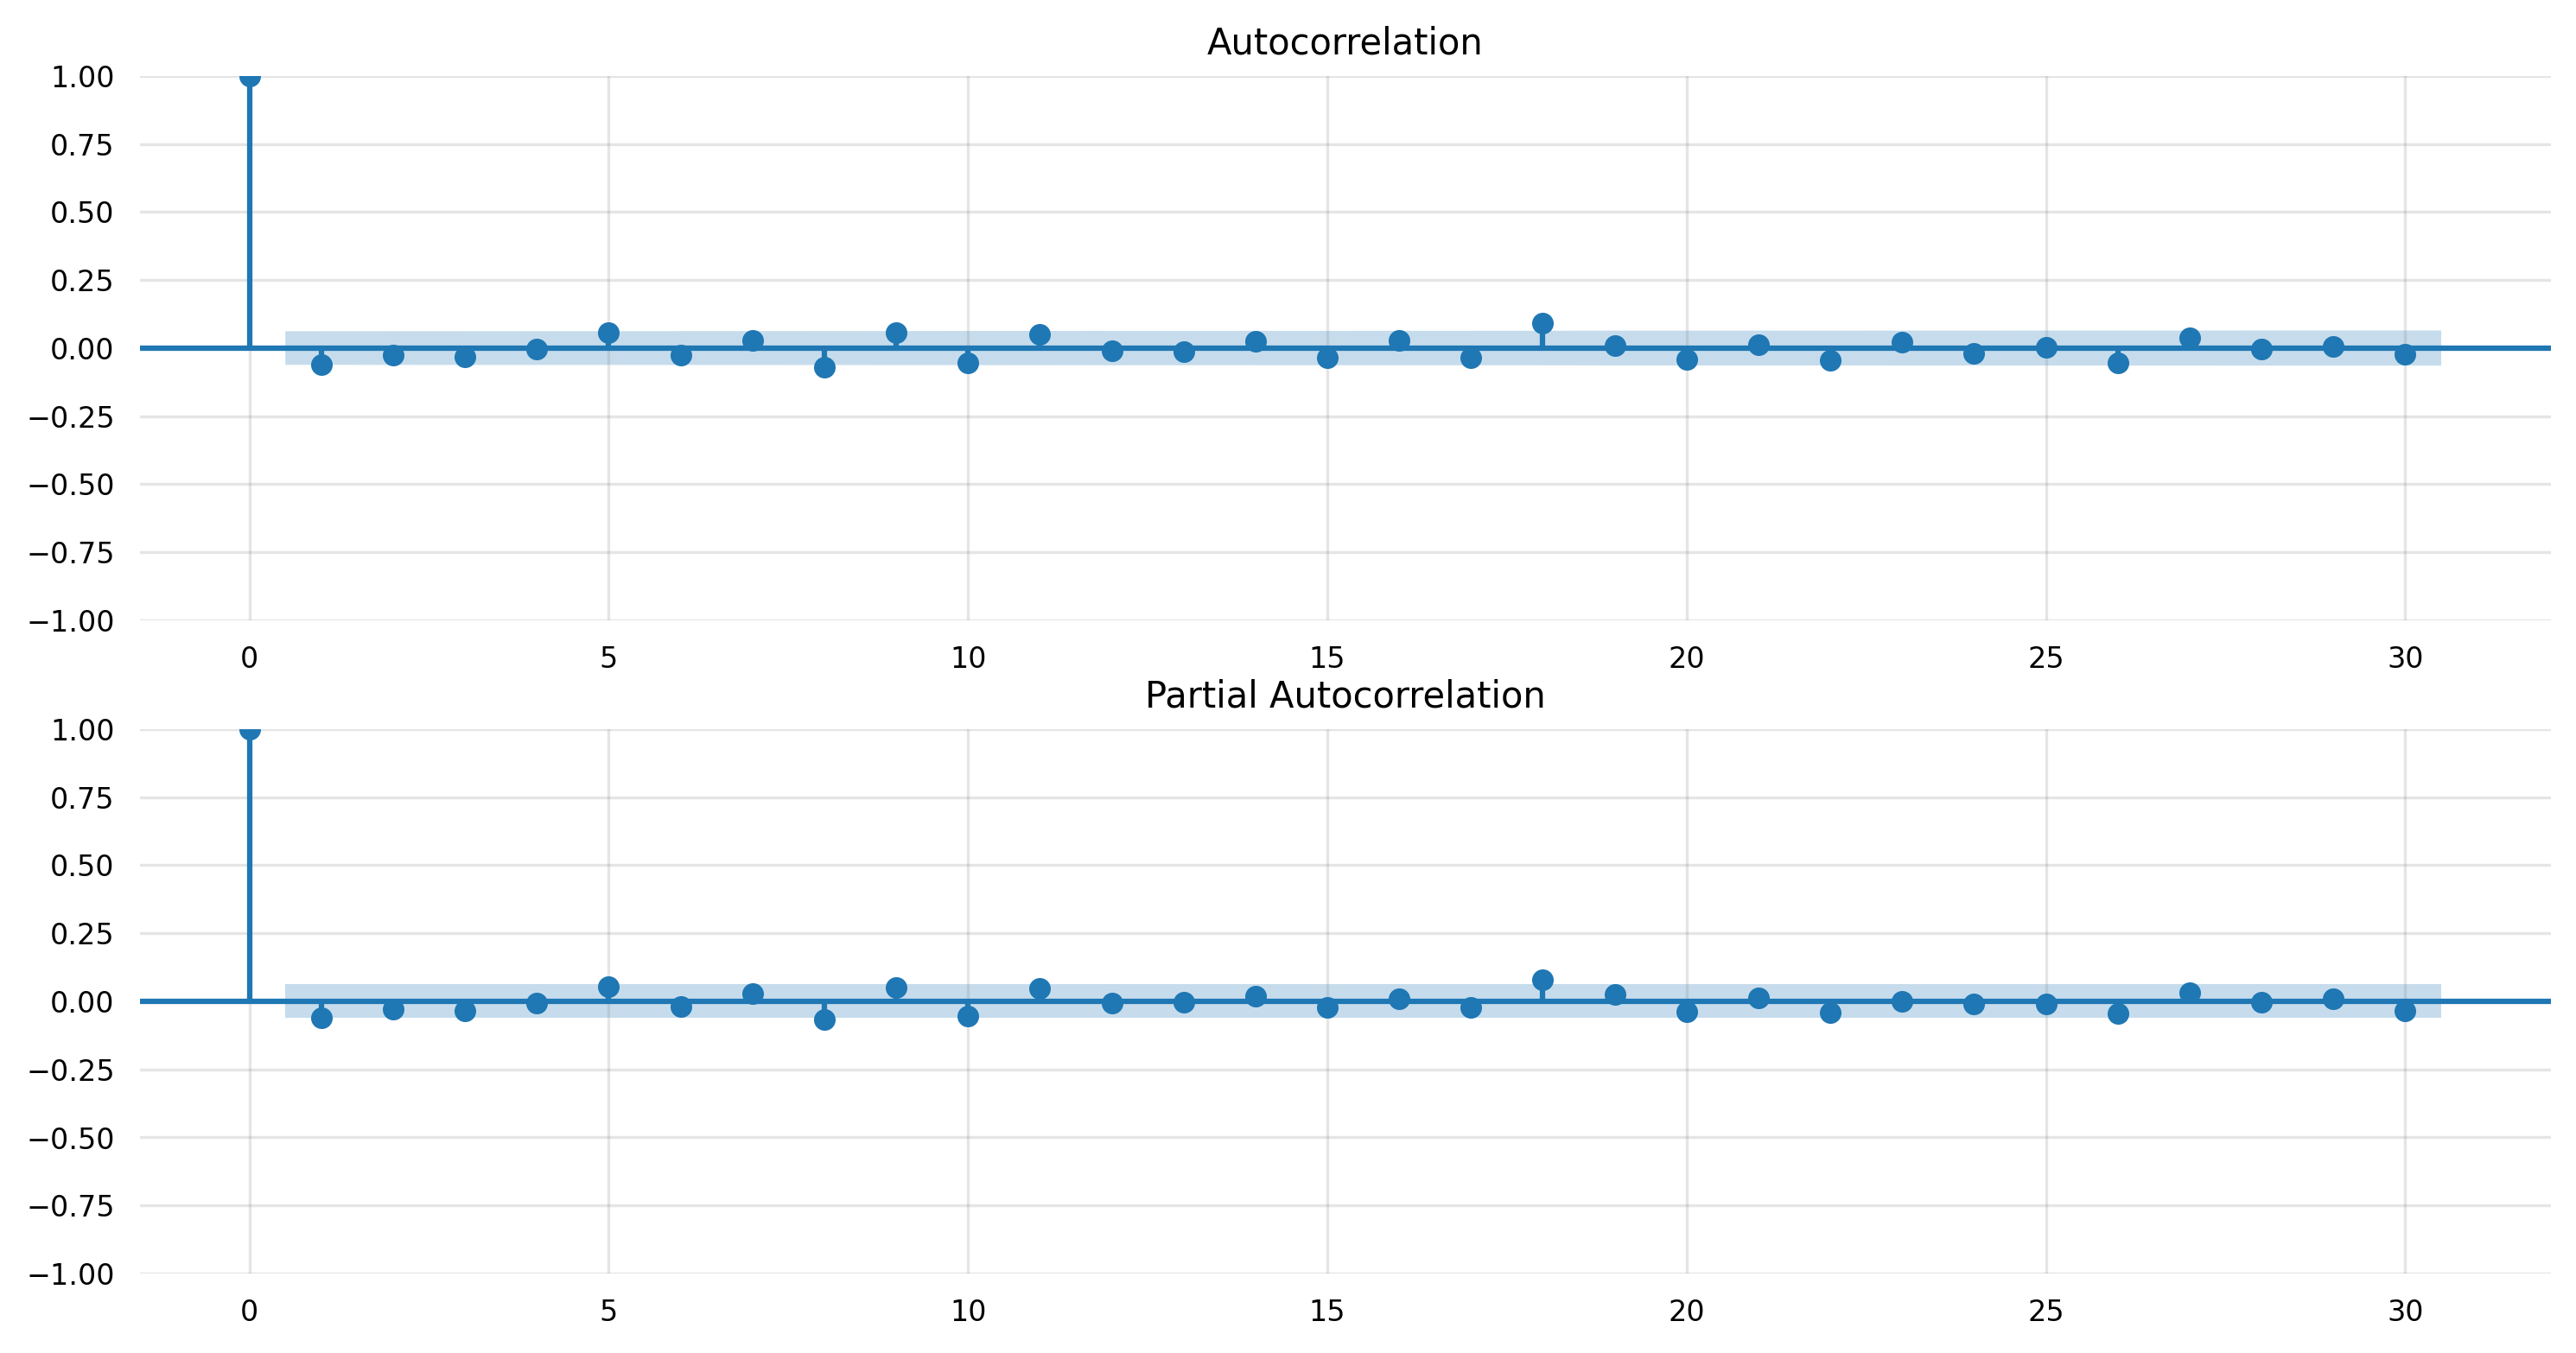

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(ts_diff, lags=30, ax=plt.gca())
plt.subplot(212)
plot_pacf(ts_diff, lags=30, ax=plt.gca())
plt.show()

In [14]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import itertools
import warnings

warnings.filterwarnings('ignore')

# Chargement des données
stock_prices = data['Close']
stock_prices = stock_prices.diff().dropna()

# Train-test split (80% training, 20% testing)
train_size = int(len(stock_prices) * 0.5)
train_data, test_data = stock_prices[:train_size], stock_prices[train_size:]

# Définir les gammes de paramètres pour SARIMA
p = d = q = range(0, 5)
P = D = Q = range(0, 5)
s = 30

# Liste de toutes les combinaisons de paramètres
sarima_params = list(itertools.product(p, d, q, P, D, Q))
best_score = float('inf')
best_params = None

for params in sarima_params:
    try:
        model = SARIMAX(train_data, 
                        order=(params[0], params[1], params[2]), 
                        seasonal_order=(params[3], params[4], params[5], s))
        model_fit = model.fit(disp=False)
        forecast = model_fit.forecast(steps=len(test_data))
        mse = mean_squared_error(test_data, forecast)
        if mse < best_score:
            best_score = mse
            best_params = params
    except:
        continue

print(f"✅ Best SARIMA Model: SARIMA{best_params} with MSE={best_score}")

# Entraîner le meilleur modèle SARIMA
best_model = SARIMAX(stock_prices, 
                     order=(best_params[0], best_params[1], best_params[2]), 
                     seasonal_order=(best_params[3], best_params[4], best_params[5], s))
best_model_fit = best_model.fit(disp=False)

# Prévisions
forecast = best_model_fit.forecast(steps=len(test_data))

# Visualisation
plt.figure(figsize=(16, 9))
plt.plot(train_data, label='Training Data')
plt.plot(test_data, label='Test Data', color='blue')
plt.plot(test_data.index, forecast, label='Forecast (Best SARIMA)', color='red')
plt.title(f'Best SARIMA Model {best_params} - Actual vs Forecasted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

: 